## Example flow to use image generation

## Load env

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
ACCOUNT_ID = os.getenv("ACCOUNT_ID")
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
CLOUD_NAME = os.getenv("CLOUD_NAME")
API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")


## Import libraries

In [2]:
import requests
import base64
import PIL
from io import BytesIO
import cloudinary
import cloudinary.uploader

from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages.ai import AIMessage
from typing import Literal
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display

c:\Users\Tom\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [3]:
# Cloudinary for image storage
cloudinary.config(
    cloud_name = CLOUD_NAME,
    api_key = API_KEY,
    api_secret = API_SECRET
)

# Gen image API fetching
API_BASE_URL = f"https://api.cloudflare.com/client/v4/accounts/{ACCOUNT_ID}/ai/run/"
headers = {"Authorization": f"Bearer {ACCESS_TOKEN}"}

# Config gemini
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Image generation function

In [4]:
def gen_image(prompt: str) -> str:
    input = { "prompt": prompt }
    model = "@cf/black-forest-labs/flux-1-schnell"
    
    response = requests.post(f"{API_BASE_URL}{model}", headers=headers, json=input)
    output = response.json()

    base64_string = output['result']['image'].strip().replace("\n", "")
    imagedata = base64.b64decode(base64_string)
    image = PIL.Image.open(BytesIO(imagedata))

    res = "test2.png"
    image.save(res)    

    return res



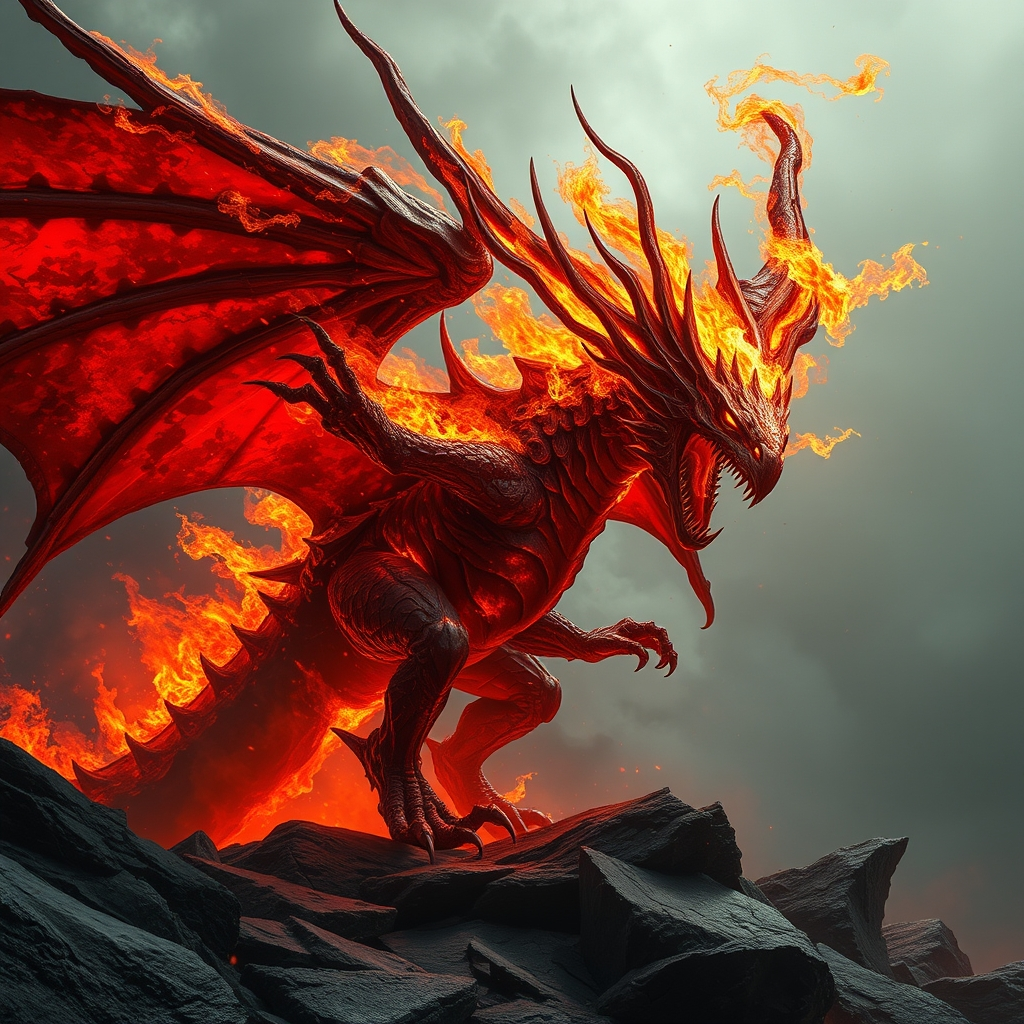

In [5]:
output = gen_image("rathalos burning flame")
Image(filename=output)

## Langchain example

In [14]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

In [6]:
class ImageState(TypedDict):

    messages: Annotated[list, add_messages]

    finished: bool

SYSINT = (
    "system",
    "You are an image editor for a popular news magazine"
    "You're main purpose is to generating eye capturing images on the landing page of the news magazine."
    "You'll be provide with a prompt, and you're job is to transform the prompt into"
    "a detailed description of the image of the landing page that you're going to create."
    "Do not provide the description back to the user, just select the description you think is the best one."
    "After that, you'll input this description into a tool called 'generate_image'"
    "Remember to use the tool immediately"
    "\n\n"
    "Do not transform the original prompt away from its original meaning. Do not go off-topic"
)

WELCOME_MSG = "Welcome to the Image News Generator. Type `q` to quit. What news image do you want to generate today"

In [7]:
def human_node(state: ImageState) -> ImageState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

In [8]:
def chatbot_with_welcome_msg(state: ImageState) -> ImageState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}

In [9]:
# Start building a new graph.
graph_builder = StateGraph(ImageState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

In [10]:
from typing import Literal


def maybe_exit_human_node(state: ImageState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()


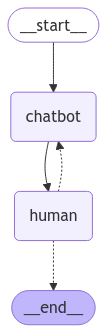

In [11]:
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [55]:
# state = chat_with_human_graph.invoke({"messages": []})

Model: Welcome to the Image News Generator. Type `q` to quit. What news image do you want to generate today


In [12]:
@tool
def generate_image(prompt: str) -> str:
    """
    Tools for generating image
    """
    output = gen_image(prompt)
    Image(filename=output)
    return "Image is already generated, here is the link for it: test2.png"


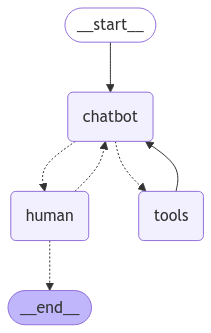

In [15]:
tools = [generate_image]
tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

def maybe_route_to_tools(state: ImageState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]
    # print(msg)
    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    # elif (msg[0][1].finds("generate") != -1):
    #     return "tools"
    else:
        return "human"

graph_builder = StateGraph(ImageState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [16]:
from langchain.callbacks.tracers import ConsoleCallbackHandler

# state = graph_with_menu.invoke({"messages": []}, config={'callbacks': [ConsoleCallbackHandler()]})
state = graph_with_menu.invoke({"messages": []})


Model: Welcome to the Image News Generator. Type `q` to quit. What news image do you want to generate today


Model: A dynamic, action-packed image depicting Spider-Man mid-air, web-slinging between skyscrapers.  The background is a vibrant, slightly blurred cityscape at sunset, with the iconic New York skyline visible. Spider-Man is sharply in focus, his suit gleaming with a subtle reflective quality.  In the foreground, a collapsing building is partially obscured by a web, suggesting a recent rescue.  The overall color palette is warm, with oranges and reds from the sunset contrasting against the cool blues and blacks of the night sky and Spider-Man's suit.  The image should convey a sense of urgency and heroism, with a slightly stylized, comic-book-inspired feel to the action and lighting.  A subtle, almost invisible, news headline banner ("Spider-Man Saves City from Catastrophic Collapse!") could be subtly placed in a corner, not to distract from the main action.

Model: ```tool_code
generate_image("A dynamic, action-packed image depicting Spider-Man mid-air, web-slinging between skyscrape

In [17]:
generate_image("A dynamic, action-packed image depicting Spider-Man mid-air, web-slinging between skyscrapers.  The background is a vibrant, slightly blurred cityscape at sunset, with the iconic New York skyline visible. Spider-Man is sharply in focus, his suit gleaming with a subtle reflective quality.  In the foreground, a collapsing building is partially obscured by a web, suggesting a recent rescue.  The overall color palette is warm, with oranges and reds from the sunset contrasting against the cool blues and blacks of the night sky and Spider-Man's suit.  The image should convey a sense of urgency and heroism, with a slightly stylized, comic-book-inspired feel to the action and lighting.  A subtle, almost invisible, news headline banner (\"Spider-Man Saves City from Catastrophic Collapse!\") could be subtly placed in a corner, not to distract from the main action.")

C:\Users\Tom\AppData\Local\Temp\ipykernel_12932\4121333437.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  generate_image("A dynamic, action-packed image depicting Spider-Man mid-air, web-slinging between skyscrapers.  The background is a vibrant, slightly blurred cityscape at sunset, with the iconic New York skyline visible. Spider-Man is sharply in focus, his suit gleaming with a subtle reflective quality.  In the foreground, a collapsing building is partially obscured by a web, suggesting a recent rescue.  The overall color palette is warm, with oranges and reds from the sunset contrasting against the cool blues and blacks of the night sky and Spider-Man's suit.  The image should convey a sense of urgency and heroism, with a slightly stylized, comic-book-inspired feel to the action and lighting.  A subtle, almost invisible, news headline banner (\"Spider-Man Saves Cit

'Image is already generated, here is the link for it: test2.png'